In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Load

In [2]:
dataset = pd.read_csv('Dataset for data_scientist test.txt')

# Some cleaning

In [3]:
dataset['date_2'] = pd.to_datetime(dataset.date_2)
dataset['date_year'] = dataset.date_2.dt.to_period('Y').astype(str)
dataset['disc_6'] = dataset.disc_6.replace({'na':np.nan}).astype(float)
dataset['label'] = dataset.label.replace({'na':np.nan}).astype(float)

dataset = dataset.dropna(subset=['label', 'disc_6']).reset_index(drop=True)

# Some additional features

In [4]:
dataset['5*6'] = dataset.disc_6*dataset.disc_5
dataset['10*9'] = dataset.cont_9*dataset.cont_10
dataset['10*9*4'] = dataset.cont_9*dataset.cont_10*dataset.cont_4

In [5]:
dataset.sample(5)

,key_1,date_2,cont_3,cont_4,disc_5,disc_6,cat_7,cat_8,cont_9,cont_10,label,date_year,5*6,10*9,10*9*4
686,na,2019-04-24,-0.98,0.91,1,5.0,surprised,purple,-1.63,-15.82,1.71,2019,5.0,25.7866,23.465806
800,FB4145,2006-05-22,-0.90,-10.39,1,21.0,surprised,orange,0.42,4.33,2.57,2006,21.0,1.8186,-18.895254
493,Xm3126,2005-05-04,1.92,-4.94,2,21.0,surprised,purple,-1.37,-13.24,3.16,2005,42.0,18.1388,-89.605672
310,Hp1551,2014-06-22,-0.30,-4.17,2,3.0,surprised,orange,-2.99,-35.35,1.90,2014,6.0,105.6965,-440.754405
252,bx5249,2011-04-01,0.84,-0.99,5,21.0,sad,purple,-1.88,-18.49,4.31,2011,105.0,34.7612,-34.413588


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key_1      812 non-null    object        
 1   date_2     812 non-null    datetime64[ns]
 2   cont_3     812 non-null    float64       
 3   cont_4     812 non-null    float64       
 4   disc_5     812 non-null    int64         
 5   disc_6     812 non-null    float64       
 6   cat_7      812 non-null    object        
 7   cat_8      812 non-null    object        
 8   cont_9     812 non-null    float64       
 9   cont_10    812 non-null    float64       
 10  label      812 non-null    float64       
 11  date_year  812 non-null    object        
 12  5*6        812 non-null    float64       
 13  10*9       812 non-null    float64       
 14  10*9*4     812 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(4)
memory usage: 95.3+ KB


# Looking for correlations

In [7]:
dataset.corr().label.sort_values(ascending=False)

label      1.000000
cont_10    0.552509
cont_9     0.552246
5*6        0.449784
10*9       0.366766
cont_3     0.361219
disc_5     0.354444
disc_6     0.340948
cont_4     0.303474
10*9*4     0.218184
Name: label, dtype: float64

# Checking variable distribution

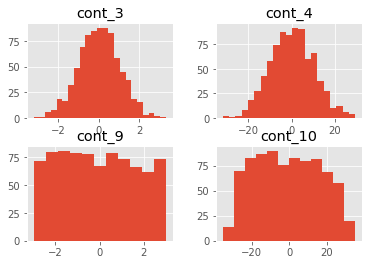

In [8]:
dataset[[col for col in dataset.columns if col.startswith('cont_')]].hist(bins='auto')
plt.show()

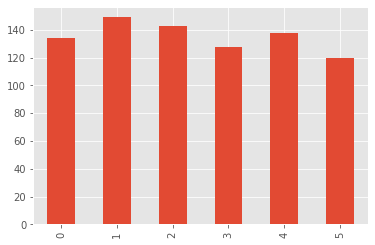

In [9]:
dataset.disc_5.value_counts().plot.bar()
plt.show()

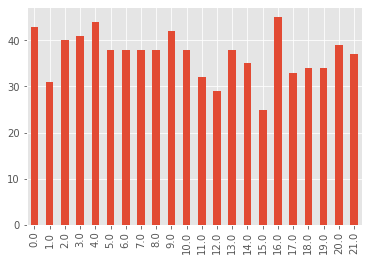

In [10]:
dataset.disc_6.value_counts().plot.bar()
plt.show()

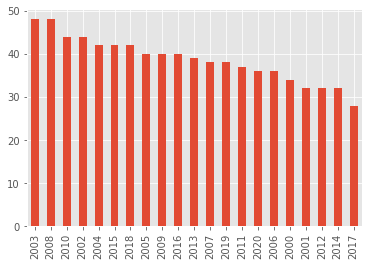

In [11]:
dataset.date_year.value_counts().plot.bar()
plt.show()

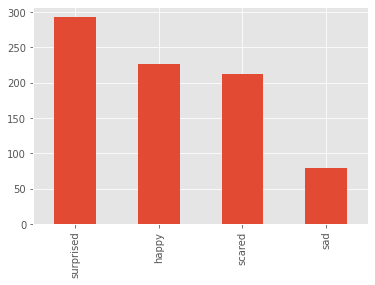

In [12]:
dataset.cat_7.value_counts().plot.bar()
plt.show()

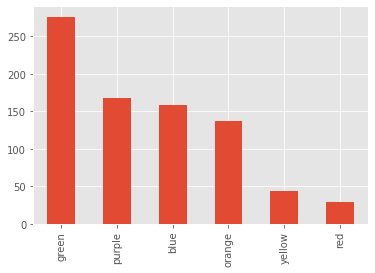

In [13]:
dataset.cat_8.value_counts().plot.bar()
plt.show()

    Since key is a name, it must povide no predictive value. 
    Date was replaced by a categorical representation.

In [14]:
dataset = dataset.drop(columns=['key_1','date_2'])
dataset_keys = dataset.key_1

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cont_3     812 non-null    float64
 1   cont_4     812 non-null    float64
 2   disc_5     812 non-null    int64  
 3   disc_6     812 non-null    float64
 4   cat_7      812 non-null    object 
 5   cat_8      812 non-null    object 
 6   cont_9     812 non-null    float64
 7   cont_10    812 non-null    float64
 8   label      812 non-null    float64
 9   date_year  812 non-null    object 
 10  5*6        812 non-null    float64
 11  10*9       812 non-null    float64
 12  10*9*4     812 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 82.6+ KB


    Separating labels from f

In [29]:
X_df = dataset.drop(columns=['label'])
X_df_scalable = X_df.drop(columns=['cat_7','cat_8','date_year'])
X_df_unscalable = X_df[['cat_7','cat_8','date_year']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df_scalable)
X_df_scaled = pd.DataFrame(X_scaled, columns=X_df_scalable.columns)

X_df = pd.concat([X_df_scaled, X_df_unscalable], axis=1) 
y_df = dataset.label

X = X_df.to_numpy()
y = y_df.to_numpy().reshape(1,-1)

# Categorical features handling.
    
    Transforming categorical values into its dummy representation.

In [36]:
X_df_dumm = pd.get_dummies(X_df)
X_df_dumm = pd.concat([X_df_dumm, X_df[['cat_8']]], axis=1)

# Train-Test splitting

In [67]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_df_dumm, X_df_dumm['cat_8']):
    X_df_train = X_df_dumm.loc[train_index]
    X_df_test = X_df_dumm.loc[test_index]
    y_df_train = y_df.loc[train_index]
    y_df_test = y_df.loc[test_index]

X_df_train = X_df_train.drop(columns=['cat_8'])
X_df_test = X_df_test.drop(columns=['cat_8'])

X_df_total = pd.concat([X_df_train, X_df_test], axis=0)
y_df_total = pd.concat([y_df_train, y_df_test], axis=0)

In [48]:
X_train = X_df_train.to_numpy()
X_test = X_df_test.to_numpy()
y_train = y_df_train.to_numpy()
y_test = y_df_test.to_numpy()

In [68]:
X_total = X_df_total.to_numpy()
y_total = y_df_total.to_numpy()

# Training

### We will train two different models, fine-tune them and evaluate them. The best one will be used to make predictions and generate payment default porbabilities.

In [49]:
from sklearn.svm import SVR

svr_param_grid = [
    {
        'C':[1, 10, 50], 
        'kernel':['rbf', 'sigmoid', 'linear'],
        'epsilon':[0.01,0.05,0.1,0.2,0.5]
    }
]

svr = SVR()

svr_grid_search = GridSearchCV(
    svr, 
    svr_param_grid, 
    cv=4,
    scoring='neg_mean_squared_error',# Satisfy lower costs or client's needs? Both 
    return_train_score=True,
    n_jobs=-1
)

svr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 50],
                          'epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
                          'kernel': ['rbf', 'sigmoid', 'linear']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [52]:
from sklearn.ensemble import RandomForestRegressor

rfr_param_grid = [
    {
        'n_estimators':[100,200,500], 
        'criterion':['mse', 'mae'],
        'min_samples_split':[2,3,5,10],
    }
]

rfr = RandomForestRegressor()

rfr_grid_search = GridSearchCV(
    rfr, 
    rfr_param_grid, 
    cv=4,
    scoring='neg_mean_squared_error', # Satisfy lower costs or client's needs? Both 
    return_train_score=True,
    n_jobs=-1
)

rfr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse', 'mae'],
                          'min_samples_split': [2, 3, 5, 10],
                          'n_estimators': [100, 200, 500]}],
             return_train_score=True, scoring='neg_mean_squared_error')

# Model evaluation

In [53]:
best_svr = svr_grid_search.best_estimator_

In [74]:
y_hat_train = best_svr.predict(X_train)
mse_train = mean_squared_error(y_train, y_hat_train)
rmse_train = np.sqrt(mse_train)
rmse_train

0.1690428393180915

In [75]:
y_hat_test = best_svr.predict(X_test)
mse_test = mean_squared_error(y_test, y_hat_test)
rmse_test = np.sqrt(mse_test)
rmse_test

0.1882610385823187

In [54]:
best_rfr = rfr_grid_search.best_estimator_

In [77]:
y_hat_train = best_rfr.predict(X_train)
mse_train = mean_squared_error(y_train, y_hat_train)
rmse_train = np.sqrt(mse_train)
rmse_train

0.10697324896712632

In [78]:
y_hat_test = best_rfr.predict(X_test)
mse_test = mean_squared_error(y_test, y_hat_test)
rmse_test = np.sqrt(mse_test)
rmse_test

0.29993087738375784

    The best model is the Support Vector Machine, for its performance on test set. Predictions will me made from that model.

In [79]:
y_hat_total = best_svr.predict(X_total)
mse_T = mean_squared_error(y_total, y_hat_total)
rmse_T = np.sqrt(mse_T)
rmse_T

0.1649373918665446

In [82]:
df_total = pd.concat([X_df_total, y_df_total], axis=1)

In [84]:
df_total['predictions'] = y_hat_total

In [85]:
df_total

,cont_3,cont_4,disc_5,disc_6,cont_9,cont_10,5*6,10*9,10*9*4,cat_7_happy,...,date_year_2013,date_year_2014,date_year_2015,date_year_2016,date_year_2017,date_year_2018,date_year_2019,date_year_2020,label,predictions
615,-0.867447,-1.350395,0.340503,-1.443599,0.425292,0.422389,-0.861717,-0.924727,-0.203774,1,...,0,0,0,0,1,0,0,0,1.90,1.909686
73,-0.867447,0.529585,-0.848696,-1.599914,-1.140731,-1.076799,-0.980555,0.349881,0.468704,0,...,0,0,0,0,0,0,0,1,1.89,1.930695
627,-1.066003,1.464085,-0.848696,-0.818341,0.851858,0.888893,-0.782492,-0.334514,0.683026,0,...,0,0,0,0,0,0,0,0,2.88,2.827098
36,-0.748314,0.024397,-0.848696,-1.443599,-1.245912,-1.362497,-0.940942,0.877675,0.003255,1,...,0,0,0,0,0,0,0,0,1.51,1.692695
594,0.095549,-0.839216,-0.254096,-0.349398,-1.701695,-1.757722,-0.346755,2.323002,-1.909503,1,...,0,0,0,0,0,0,0,0,2.06,2.067176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,0.393383,0.256025,0.340503,1.682691,0.489569,0.454841,1.515030,-0.882060,-0.023898,1,...,0,0,0,0,0,0,0,0,3.71,3.474356
716,-0.033512,-0.522725,1.529703,1.682691,1.366075,1.209941,3.178753,0.604509,-0.621724,1,...,0,0,1,0,0,0,0,0,4.98,4.816547
384,-0.321419,0.478667,1.529703,0.901119,-1.397839,-1.320772,2.188442,1.044361,0.653277,0,...,0,0,0,0,0,0,0,0,3.78,3.418736
591,0.393383,0.067328,-0.848696,-0.505712,1.506316,1.568077,-0.703267,1.355106,0.088925,0,...,1,0,0,0,0,0,0,0,3.83,3.986301


# Conclutions and recommendations
    - Data was loaded and cleaned.
    - Features were studied. Distributions were analyzed. This analysis provided insights on how to split the data.
    - Some features with good correlation value with the labels were created.
    - Data was split into training and test sets.
    - Two type of models were trained. The best model for each type was obtained using a hyperparameter search, which ran on a cross-validation method fashion. A single model was obtained from each search, of which the best was chosen. A support vector machine regressor was the winner model, and final predictions were generated from this model.
    - More models, more tuning, more features, best feature selection, and more data could improve the performance of a final model.
    - Meaning of data could provide insights for best feature selection and additional feature creation, possibly allowing us to create a better model.